# Using user features to improve text classification
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* SVM
* Random forest
* Gradient Boosting
* Multilayer Perceptron


**References:**
*

In [1]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
from utils import preprocess
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# K-Fold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
sns.set(style="darkgrid")



In [2]:
base = '2018'
subset = 'user_features'
results_dir = 'results/' + str(base) + '/' + subset + '/ml/'
results_dir

'results/2018/user_features/ml/'

In [9]:
#data_dir = 'data/' + str(base) #+ '/vis_processed_texts.p'
#filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv('data/2018/high quality labels/fakeWhatsApp.BR_2018.csv')
#non_viral_mis = df[(df['viral']==0) & (df['misinformation']==1)]['text'].unique()
#non_viral_non_mis = df[(df['viral']==0) & (df['misinformation']==0)].sample(n=len(non_viral_mis))['text'].unique()
#non_viral = list(non_viral_mis) + list(non_viral_non_mis)
df.head()

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,characters,words,viral,sharings,text,misinformation,ambiguity,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0,0.0,bolsonaro estar preparado pra responder assim ...,bolsonar est prepar pra respond assim . . .,bolsonaro estar preparar pra responder assim ....
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,...,5,1,0,1,Boaaa,-1,-1.0,boaaa,boaa,boaaa
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >


In [4]:
df['preprocessed_text_lemma'] = [preprocess(t, lemma=True) for t in df['text']]

In [5]:
def processes_nan(text):
    if type(text) is str:
        return text            
    else:
        return ''
df['preprocessed_text'] = [processes_nan(text) for text in df['preprocessed_text']]
df['preprocessed_text_stemmed'] = [processes_nan(text) for text in df['preprocessed_text_stemmed']]
df['preprocessed_text_lemma'] = [processes_nan(text) for text in df['preprocessed_text_lemma']]
df.to_csv('data/2018/high quality labels/fakeWhatsApp.BR_2018.csv',index=False)

# Get user features

In [5]:
#X_w2v = vectorize_corpus(w2v,df['preprocessed_text'])

In [6]:
len(df[(df['id']==-4391661641377612003) & (df['midia']==1)])

130

In [7]:
df[(df['id']==-3818310068976662355)]['midia'].sum()

654

In [6]:
df['midia'].sum()

126349

In [13]:
df

,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,characters,words,viral,sharings,text,misinformation,ambiguity,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0,0.0,bolsonaro estar preparado pra responder assim ...,bolsonar est prepar pra respond assim . . .,bolsonar est prepar pra respond assim . . .
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,...,5,1,0,1,Boaaa,-1,-1.0,boaaa,boaa,boaa
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282596,-3459365403520904542,28/10/18,21:48,?,?,?,?,?,2018_59,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >
282597,-3459365403520904542,28/10/18,22:06,?,?,?,?,?,2018_59,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >
282598,-3459365403520904542,28/10/18,22:08,?,?,?,?,?,2018_59,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >
282599,-3459365403520904542,28/10/18,22:12,?,?,?,?,?,2018_59,1,...,25,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,< arquivo midia oculto >,< arqu mid ocult >,< arqu mid ocult >


In [10]:
def get_text_content(user, column):
    msgs = df[(df['id']==user) & (df['midia']==0)][column]
    msgs = list(msgs.values)
    msgs = " ".join(msgs)
    return msgs


def get_user_features(df,users):
    '''
    
    '''
    virals = []
    texto = []
    media = []
    msg_str = []
    preprocessed_msg_str = []
    stemmed_msg_str= []
    lemma_msg_str = []
    misinformation = []
    n_groups = []
    n_users = []
    strenght = []
    n_users_mis = []
    strenght_mis = []
    urls = []
    mis_ratio = []
    
    for user in users.index:
        virals.append(len(df[(df['id'] == user) & (df['viral']==1)]))
        texto.append(len(df[(df['id'] == user) & (df['midia']==0)]))
        media.append(len(df[(df['id'] == user) & (df['midia']==1)]))
        misinformation.append(len(df[(df['id'] == user) & (df['misinformation']==1)]))
        n_groups.append(df[df['id']==user]['group'].nunique())
        urls.append(len(df[(df['id'] == user) & (df['url']==1)]))
        mis_ratio.append(len(df[(df['id'] == user) & (df['misinformation']==1)])/len(df[df['id']==user]))
        
        u_degree = 0
        u_strenght = 0
        groups = df[df['id']==user]['group'].unique()
        
        u_degree_mis = 0
        u_strenght_mis = 0
        
        for g in groups:
            users_in_group = df[df['group']==g]['id'].nunique()
            messages_in_group = len(df[(df['id']==user) &(df['group']==g)])            
            u_strenght += users_in_group*messages_in_group
            u_degree += users_in_group
            
            # misinformations
            users_misinformed = 0
            misinformation_in_group = len(df[(df['id']==user) & (df['group']==g) & (df['misinformation']==1)])
            if misinformation_in_group > 0:
                users_misinformed = users_in_group                
            u_strenght_mis += users_misinformed*misinformation_in_group
            u_degree_mis += users_misinformed  
            
        n_users.append(u_degree)
        strenght.append(u_strenght)
        n_users_mis.append(u_degree_mis)
        strenght_mis.append(u_strenght_mis)        
        
        # full text
        msg_str.append(get_text_content(user, 'text'))        
        # pre-processed text        
        preprocessed_msg_str.append(get_text_content(user, 'preprocessed_text'))        
        # stemmed text
        stemmed_msg_str.append(get_text_content(user, 'preprocessed_text_stemmed'))        
        # lemmatized text
        lemma_msg_str.append(get_text_content(user, 'preprocessed_text_lemma')) 
        
    topUsers = pd.DataFrame({'id':users.index, 'total_messages':users.values, 'viral_messages':virals, 
                             'texts':texto, 'midia':media, 'urls':urls,
                             'number_of_groups':n_groups, 'reached_users':n_users,'messages_for_reached_user':strenght,
                             'misinformations': misinformation, 'misinformation_ratio':mis_ratio,
                             'users_misinformed':n_users_mis, 'misinformation_for_reached_user':strenght_mis,                             
                             'messages':msg_str, 'preprocessed_messages':preprocessed_msg_str,
                             'preprocessed_stemmed_messages':stemmed_msg_str, 'preprocessed_lemmatized_messages':lemma_msg_str})    
    return topUsers
    

def getTopUsers(df,top=10):
    groupedByid = df.groupby(['id']).count()
    groupedByid = groupedByid.sort_values('date', ascending=False)[0:top]['date']
    return get_user_features(df,groupedByid)

#df_users = getTopUsers(df,None)
df_users = pd.read_csv('data/2018/user_features.csv')
df_users.sort_values('total_messages', ascending=False).head()

,id,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user,misinformations,misinformation_ratio,users_misinformed,misinformation_for_reached_user,messages,preprocessed_messages,preprocessed_stemmed_messages,preprocessed_lemmatized_messages
0,-3818310068976662355,4396,22,3742,654,139,1,153,672588,0,0.000000,0,0,Ontem eu vi um vídeo de um travesti xingando a...,ontem vi video travesti xingando ser blasfemou...,ont vi vide travest xing ser blasfem jesu comi...,ontem vir virdeo travestir xingar ser blasfema...
1,5782050016593913959,2332,223,972,1360,224,11,1710,498161,19,0.008148,302,5738,Fazer campanha contraria tbm ajuda É verdade i...,fazer campanha contraria tbm ajuda verdade ? v...,faz campanh contr tbm ajud verdad ? vao entrev...,fazer campanha contrariar tbm ajudar verdade ?...
2,-2072140886659020977,2064,227,948,1116,295,3,534,391490,23,0.011143,228,3436,Kkkk as urnas que são fraudadas kkkk essa desc...,kkk urnas sao fraudadas kkk desculpe ha ja deu...,kkk urn sao fraud kkk desculp ha ja deu ne ? ?...,kkk urna sao fraudar kkk desculpar ha ja dar n...
3,2839535797075678550,2020,104,1587,433,154,5,895,644390,8,0.003960,759,2317,"*Ordem em meio a caos, o sucesso das escolas m...","* ordem meio caos , sucesso escolas militares ...","* ord mei cao , sucess escol milit . * \n \n _...","* ordem mear caos , sucesso escola militar . *..."
4,170916900626840870,1810,96,828,982,253,1,153,276930,10,0.005525,153,1530,Para bom entendedor meia palavra basta.\nNo ge...,"bom entendedor meia palavra basta . \n geral ,...","bom entend mei palavr bast . \n geral , ignor ...","bom entendedor meio palavra basto . \n geral ,..."


In [15]:
# df_users['superspreader'] = [1 if x > 100 else 0 for x in df_users['total_messages']]
df_users['source_of_misinformation'] = [1 if x >= 0.05 else 0 for x in df_users['misinformation_ratio']]
df_users['superspreader'] = [1 if x > 1000 else 0 for x in df_users['misinformation_for_reached_user']]

In [8]:
df_users.to_csv('data/2018/user_features.csv',index = False)

In [10]:
df_users.columns
col = ['viral_messages', 'texts', 'midia', 'urls', 'number_of_groups',
       'reached_users', 'messages_for_reached_user', 'misinformations','superspreader']
plot_df = df_users[col]

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


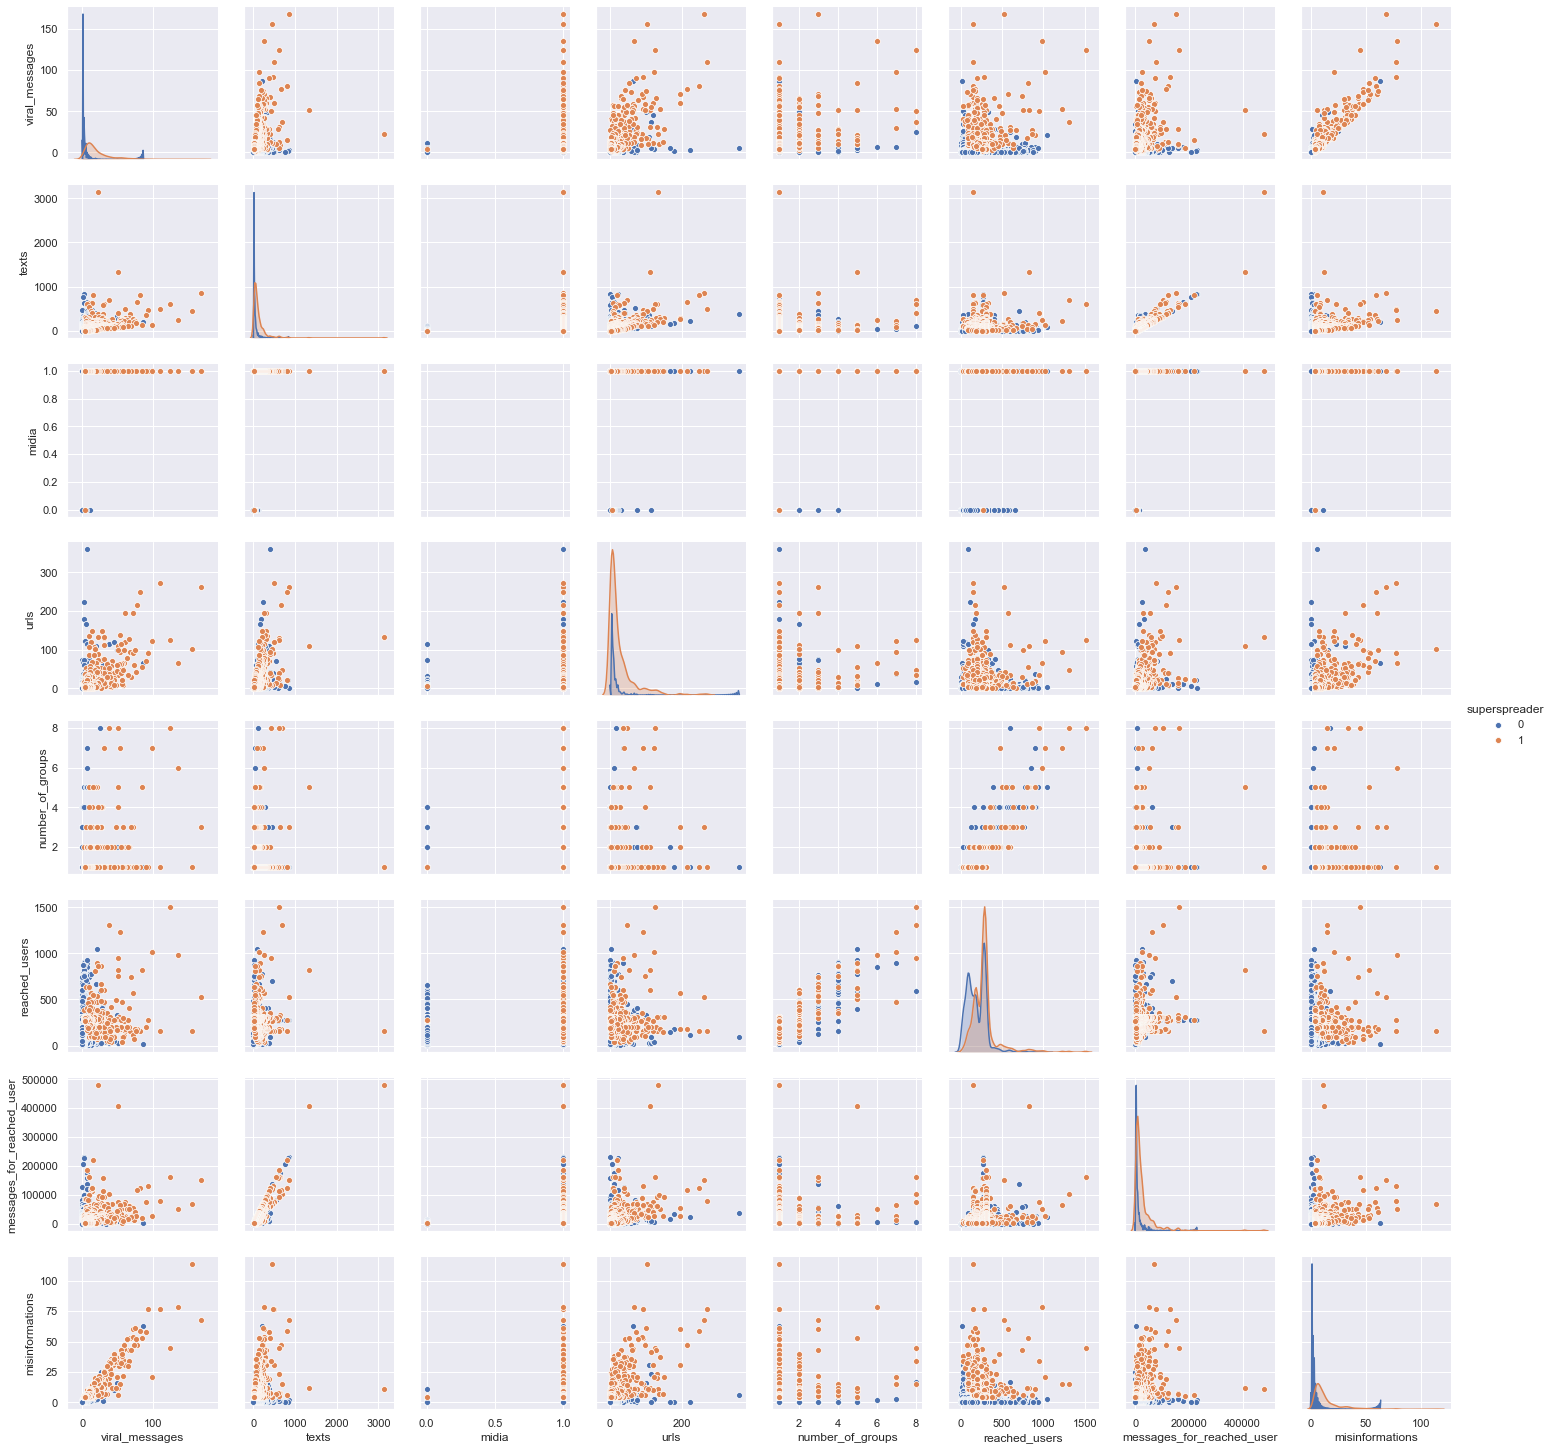

In [11]:
sns.pairplot(plot_df, hue = 'superspreader')

In [12]:
cols_users = df_users.columns
corrM = df_users[cols_users[1:]].corr()
(corrM['misinformations']).to_frame().style.background_gradient(cmap='Blues')

,misinformations
total_messages,0.452216
viral_messages,0.946397
texts,0.451823
midia,0.141915
urls,0.618797
number_of_groups,0.188578
reached_users,0.097497
messages_for_reached_user,0.372315
misinformations,1.000000
misinformation_ratio,0.294316


# Was most of misinformation spread by superspreaders?

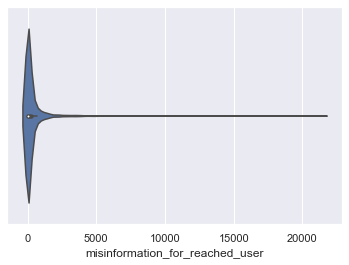

In [13]:
values = df_users['misinformation_for_reached_user']
ax = sns.violinplot(x=values)

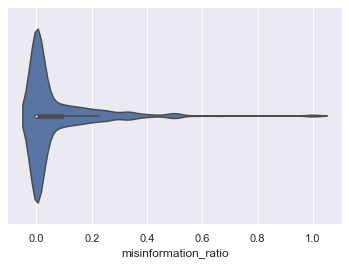

In [14]:
values = df_users['misinformation_ratio']
ax = sns.violinplot(x=values)

In [11]:
# groupedByid = df.groupby(['id']).count()
# groupedByid = groupedByid.sort_values('date', ascending=False)['date']
# print(len(groupedByid))
# mask = groupedByid.values >= 100
# groupedByid[mask]

superspreaders = set(df_users[df_users['misinformation_for_reached_user'] >= 1000]['id'])
superspreaders = set(df_users[df_users['misinformation_ratio'] >= 0.1]['id'])
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False

# mis_by_superspreaders = df[[]]
superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,superspreaders))
    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]
print('total superspreaders',len(df_superspreaders))
print('proportion of superspreaders {a:.2f}'.format(a = len(superspreaders)/len(df_users)))
print('proportion of misinformation sent by superspreaders: {a:.2f}'.format(a = len(df_superspreaders)/total_mis))

active_users = set(df_users[df_users['total_messages'] >= 100]['id'])
active_mask = []
for u in df['id']:
    active_mask.append(messages_by_superspreaders(u,active_users))

# print("Geeks: {a:5d},  Portal: {p:8.2f}".format(a = 453, p = 59.058))


total misinformation:  9859
total superspreaders 7235
proportion of superspreaders 0.24
proportion of misinformation sent by superspreaders: 0.73


# User features exploration

In [16]:
df_users.describe()

,id,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user,misinformations,misinformation_ratio,users_misinformed,misinformation_for_reached_user,source_of_misinformation,superspreader
count,5.364000e+03,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000
mean,8.021198e+16,27.390567,2.947614,26.564504,0.826063,4.576063,1.122483,202.440529,5645.274609,1.837994,0.071788,75.899515,326.333893,0.314691,0.078859
std,5.348179e+18,77.863934,8.687032,77.812483,0.379091,15.967919,0.509197,123.456464,16882.938656,5.562290,0.141169,117.740874,1033.675022,0.464436,0.269544
min,-9.222736e+18,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.509061e+18,2.000000,0.000000,2.000000,1.000000,0.000000,1.000000,103.000000,290.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.194486e+17,7.000000,0.000000,6.000000,1.000000,1.000000,1.000000,198.000000,1088.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.741235e+18,23.000000,2.000000,22.000000,1.000000,3.000000,1.000000,278.000000,4224.500000,1.000000,0.090909,142.000000,265.000000,1.000000,0.000000
max,9.222358e+18,3134.000000,168.000000,3133.000000,1.000000,359.000000,8.000000,1508.000000,479502.000000,114.000000,1.000000,1477.000000,21406.000000,1.000000,1.000000


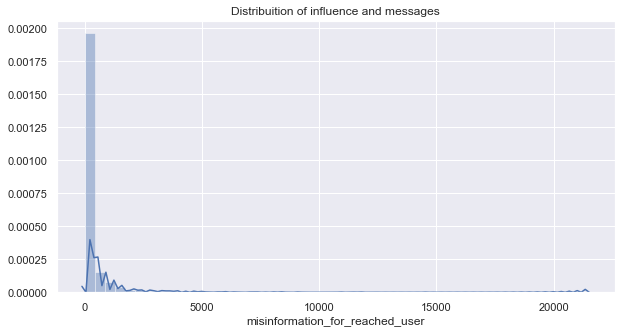

In [17]:
plt.figure(figsize=(10, 5))
plt.title('Distribuition of influence and messages')
influence = df_users['messages_for_reached_user']
#mu = influence.mean()
#std = influence.std()

#sns.distplot((influence-mu)/std, hist = False, kde = True, label = 'influence')
influence = df_users['misinformation_for_reached_user']
#mu = influence.mean()
#std = influence.std()
sns.distplot((influence), hist = True, kde = True, label = 'misinformation influence')
plt.show()

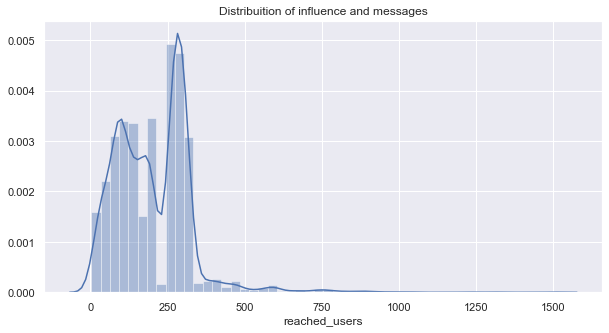

In [18]:
plt.figure(figsize=(10, 5))
plt.title('Distribuition of influence and messages')
influence = df_users['reached_users']
#mu = influence.mean()
#std = influence.std()
sns.distplot(influence, hist = True, kde = True, label = 'reached users')
#influence = df_users['misinformations']
#mu = influence.mean()
#std = influence.std()
#sns.distplot(influence, hist = True, kde = True, label = 'misinformations')
plt.show()

# Word2Vec training

In [19]:
corpus = df['text'].unique()
print(len(corpus))

114445


In [20]:
#pre_corpus = [preprocess(cp,rpunct=True) for cp in corpus]

In [21]:
#pickle.dump(pre_corpus, open( "data/2018/pre_processed_corpus.p", "wb" ))
pre_corpus = pickle.load(open( "data/2018/pre_processed_corpus.p", "rb" ) )
pre_corpus = [p.split() for p in pre_corpus]

In [22]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()

#model = Word2Vec(min_count=1)
#model.build_vocab(pre_corpus)  # prepare the model vocabulary
#model.train(pre_corpus, total_examples=model.corpus_count, epochs=1000, compute_loss=True, callbacks=[epoch_logger])
#model = Word2Vec(sentences=pre_corpus, vector_size=100, window=5, min_count=1, workers=4)
#model.save("data/2018/word2vec.model")

In [23]:
w2v = Word2Vec.load("data/2018/word2vec.model")

In [24]:
w2v.most_similar(positive=['deus'])

<ipython-input-24-926b757a3861>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar(positive=['deus'])


[('senhor', 0.6223440170288086),
 ('ocaso', 0.5645010471343994),
 ('acrescentem', 0.5391051769256592),
 ('amém', 0.5350048542022705),
 ('jesus', 0.5230710506439209),
 ('ti', 0.5007505416870117),
 ('gracioso', 0.4834190309047699),
 ('🙏', 0.47757846117019653),
 ('orar', 0.4667148292064667),
 ('oração', 0.46602940559387207)]

# Data selection

In [158]:
#df_unique = df[active_mask]
df_unique = df.copy()
df_unique = df_unique[(df_unique['viral']==1)]
#df_unique = df_unique[(df_unique['viral']==1) | (df_unique['misinformation']==1)]
df_unique = df_unique[df_unique['midia']==0]

#df_users = df_users[df_users['total_messages'] >= 100]

#df_unique = df_unique.drop_duplicates(subset=['text','id'])
df_unique = df_unique.drop_duplicates(subset=['text'])

#df = pd.concat([df,non_viral_mis])
#df = df[df['words']>50]

print(len(df_unique))
df_unique.head(5)   

5284


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation,preprocessed_text
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0,o bolsonaro estar preparar responder assim
10,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1,o dia [num] outubro votar esquecer esquerdopat...
15,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0,dever aborrecimento variar rede social postar ...
18,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,eu gostar pedir todo grupo entrar neste link v...
36,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1,comer coisa chefe jacaré aparecer video balear...


In [159]:
# misinformation = list(df[df['misinformation']==1]['text'])
# misinformation = [preprocess(m,semi=True, rpunct = False, remoji = True) for m in misinformation]
# misinformation = ' '.join(misinformation)
# misinformation

In [160]:
# text_file = open('misinformation.txt','wt')
# text_file.write(misinformation)
# text_file.close()

# Let's take a look in the data

In [161]:
t = df_unique[df_unique['misinformation']==1]['text'].unique()[0]
t

'No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.'

In [162]:
for m in df_unique[df_unique['misinformation']==1]['text'].unique()[0:10]:
    print()
    print(m)
    print()
    print('..................................')


No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.

..................................

Como são as coisas.
Chefe do jacaré aparece no video baleado e pessoal no video falando que é morador, falam muita merda tentando colocar as forças armadas como vilão.
Quando chegou no hospital foi reconhecido e preso pela PM.

..................................

*No Ceará, o Comando Vermelho( CV ) PROIBIU propaganda de BOLSONARO  nos territórios que* *"administra"*
*Somente LULA E CIRO Podem.  Por serem aliados do CRIME.*
Alguém tem dúvida agora da quadrilha?  

https://www.opovo.com.br/jornal/reportagem/2018/08/a-interferencia-das-faccoes-criminosas-no-processo-eleitoral.html

*Agora é oficial*

..................................

Como falar que o cara não pode ser presidente se em 27 minutos ele:
- lembrou que o bonner levou chifre
- que bonner ganha 4x mais que a Renata
- Mostrou que o kit gay pode ser usado na escola mas não mostrado na TV 22h d

In [163]:
for m in df_unique[df_unique['misinformation']==0]['text'].unique()[0:10]:
    print()
    print(m)
    print()
    print('..................................')


O Bolsonaro tem que estar preparado pra responder assim...

..................................

Devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política,agora so mulheres bonitas...

..................................

EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM NESTE LINK VOTE E ESCOLHA SEU CANDIDATO A PRESIDENTE E COMPARTILHEM AO MAXIMO NAS REDES SOCIAIS DE NORTE A SUL DE LESTE A OESTE , INDIFERENTE DE SUA IDEOLOGIA 

*Detalhe:Vc não consegue votar 2 vezes ou mais.*

https://www.opinionstage.com/palmelonews1/em-quem-vc-vota-para-presidente

..................................

A ratoeira funcionou mais a ratazana aguentou a dor calada kkkkkkkk

..................................

Duas das maiores potências em vendas no Mundo, Coca Cola e Havaianas, se uniram para a maior campanha educacional visando a redução da criminalidade no país.

..................................

Relaxando no sofá, barriguinha plusize, 9mm na cintura, sem coldre, no pelo, com sa

# Corpus statistics

In [164]:
df_unique.describe()[['characters','words','sharings']]

,characters,words,sharings
count,5284.000000,5284.000000,5284.000000
mean,484.764194,74.220855,3.950038
std,938.905845,148.203533,5.363783
min,23.000000,6.000000,2.000000
25%,95.750000,13.000000,2.000000
50%,177.000000,25.000000,2.000000
75%,410.250000,63.000000,4.000000
max,15683.000000,2664.000000,91.000000


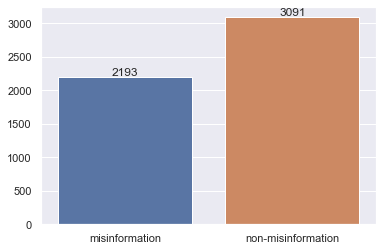

In [165]:
texts = df_unique['text']
y = df_unique['misinformation']
users = df_unique['id']

#print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [166]:
print(len(texts))
print(len(y))
print(len(users))

5284
5284
5284


In [167]:
def avgSizeWords(string):
    list_string = string.split()
    chars = np.array([len(s) for s in list_string])
    return chars.mean()    
df_unique['types'] = [len(set(t.split())) for t in df_unique['text']]
df_unique['types/token ratio'] = df_unique['types']/df_unique['words']
df_unique['char/word ratio'] = df_unique['characters']/df_unique['words']
df_unique['average chars by word'] = [avgSizeWords(t) for t in df_unique['text']]

In [168]:
mis = df_unique[df_unique['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].mean().to_frame().rename(columns={0: "misinformation"})
non_mis = df_unique[df_unique['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].mean().to_frame().rename(columns={0: "non-misinformation"})
mis.join(non_mis, lsuffix='_misinformation', rsuffix='_non-misinformation')

,misinformation,non-misinformation
words,106.556772,51.279198
types,73.787506,38.030087
types/token ratio,0.855165,0.912381
characters,674.312358,350.283727
char/word ratio,6.727408,7.277105
average chars by word,5.669311,6.242654
sharings,4.830825,3.325137


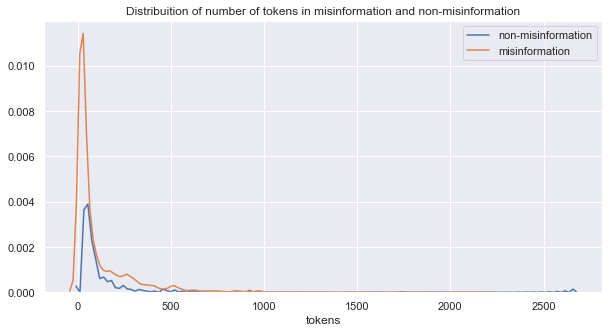

In [169]:
df_unique['tokens'] = df_unique['words']
plt.figure(figsize=(10, 5))
plt.title('Distribuition of number of tokens in misinformation and non-misinformation')
sns.distplot(df_unique[df_unique['misinformation']==0]['tokens'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df_unique[df_unique['misinformation']==1]['tokens'], hist = False, kde = True, label = 'misinformation')
plt.show()

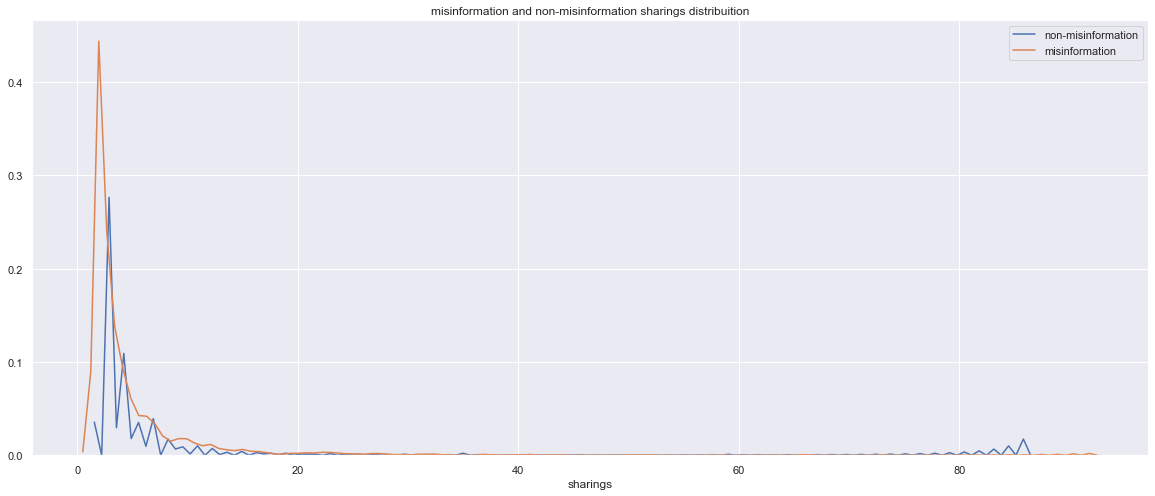

In [170]:
plt.figure(figsize=(20, 8))
plt.title('misinformation and non-misinformation sharings distribuition')
sns.distplot(df_unique[df_unique['misinformation']==0]['sharings'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df_unique[df_unique['misinformation']==1]['sharings'], hist = False, kde = True, label = 'misinformation')
plt.show()

# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [92]:
df_unique.head()

,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,viral,sharings,text,misinformation,preprocessed_text,types,types/token ratio,char/word ratio,average chars by word,tokens
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,1,2,O Bolsonaro tem que estar preparado pra respon...,0,o bolsonaro estar preparar responder assim,9,1.000000,6.444444,5.555556,9
10,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,1,2,"No dia 07 de Outubro, quando for votar, não es...",1,o dia [num] outubro votar esquecer esquerdopat...,18,1.000000,5.500000,4.555556,18
15,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,...,1,6,Devido a aborrecimentos nas varias redes socia...,0,dever aborrecimento variar rede social postar ...,17,1.000000,6.705882,5.764706,17
18,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,eu gostar pedir todo grupo entrar neste link v...,40,0.851064,7.021277,5.978723,47
36,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,...,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1,comer coisa chefe jacaré aparecer video balear...,34,0.871795,5.794872,4.820513,39


In [93]:
#df_unique['pre_processed_text'] = [preprocess(t) for t in texts]
#df_unique['semi_processed_text'] = [preprocess(t,semi=True) for t in texts]
#non_viral = [preprocess(t,semi=True) for t in non_viral]
#df.to_csv('data/2018/fakeWhatsApp.BR_2018_processed.csv',index = False)

In [189]:
pro_texts = df_unique['preprocessed_text']
pro_texts.sample(10)

28064    quererer ir camiseta bolsonaro blz reclamar dp...
21432     🔴 atenção 🔴 empresar prometer fechar demitir ...
42763    o professoro globo dizer q professor formodo p...
8221     estar vender ranger rouve evocar [num] falto [...
78027    casamentar joão pessoa dia [num] [num] [num] v...
6688     haddad odiar brasil lembrarr dessar episódio p...
36996         mega carreata haddad aracati ce preocupante 
97160    hoje último dia filiação enviar tse somente ab...
28122    haddad descolar lula haddad dizer social democ...
97405    pessoal dia hoje direito cabuçu estar reunir a...
Name: preprocessed_text, dtype: object

In [190]:
#list(zip(pro_texts[100:120], semi_pro_texts[100:120]))

In [191]:
print(len(pro_texts))
print(len(y))

5284
5284


# Experiments and models

In [192]:
experiments = ['word2vec','word2vec_pre_processed','word2vec_oversampling', 'word2vec_pre_processed_oversampling']
models = ['lr','lsvm','sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']
print(len(models))

experiment = experiments[0]
model = models[1]
print(experiment, model)

8
word2vec lsvm


## Vectorization
### Word2Vec

In [193]:
a = 'a'
type(a) == str

True

In [194]:
def vectorize_text(model, text, method='mean'):
        """
        Convert all words in a text to their embedding vector
        and calculate a vector for the text, by the mean or the sum of word vectors
        Parameters
        ----------
        text: str
        Text from wich the word vector's will be calculated    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        vec: numpy.ndarray 
        Array of the word embeddings from the given text 
        """
        n = model.vector_size
        X = np.empty(shape=[0, n])
        if type(text) != str:
            return np.zeros(n)
        
        words = text.split()
        for word in words:
            try:
                vec = model[word]
                X = np.append(X,[vec], axis = 0)
            # if oov:    
            except:
                #print('word not in vocabulary: ', word)
                continue
        if X.size == 0:
            vec = np.zeros(n)
        elif method == 'mean':
            vec = np.mean(X,axis=0)
        elif method == 'sum':
            vec = np.sum(X,axis=0)
        return vec
    
def vectorize_corpus(model, corpus, method='mean'):
        """
        Convert all texts in a corpus to vectors
        Parameters
        ----------
        corpus: list
        List of texts    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        X: numpy.ndarray 
        2D Array of vectors from each text in corpus
        """
        X = [vectorize_text(model, text, method=method) for text in corpus]
        X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
        return X

x = vectorize_corpus(w2v, ['tcheng vrac'])
x
#vectorizer = defineVectorizing(experiment)
#X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)

<ipython-input-194-07e886f4fa06>:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = model[word]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

### TF-IDF

In [195]:
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), token_pattern = r'[^\s]+')
#vectorizer.fit(texts_train)   
#X_train = vectorizer.transform(texts_train)
#X_test = vectorizer.transform(texts_test)

## Models training and test

In [196]:
def lr_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('Logistic Regression')
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=print_c)

def nb_eval(X_train,y_train,X_test,y_test, print_c = False):    
    if 'bow' in experiment:
        #print('Bernoulli Naive-Bayes')
        nb = BernoulliNB().fit(X_train, y_train)
    elif 'tfidf' in experiment:
        #print('Complement Naive-Bayes')
        nb = ComplementNB().fit(X_train, y_train)
    # print('Bernoulli Naive-Bayes')
    y_pred = nb.predict(X_test)
    y_prob = nb.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=print_c)

def lsvm_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('Linear Support Vector Machine')
    svm = LinearSVC(dual=False).fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return getTestMetrics(y_test, y_pred, full_metrics = True,print_charts=print_c)

def sgd_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('Linear SVM with SGD training')
    sgd = SGDClassifier().fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    return getTestMetrics(y_test, y_pred, full_metrics = True,print_charts=print_c)

def svm_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('SVM with RBF kernel')
    #svm = SVC(probability=True).fit(X_train, y_train)
    svc = SVC(probability=True).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_prob = svc.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred,y_prob, full_metrics = True,print_charts=print_c)

def knn_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('KNN')
    knn = KNeighborsClassifier(weights='distance',n_jobs=-1).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=print_c)

def rf_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('Random Forest')
    #rf = RandomForestClassifier(n_estimators=200,n_jobs=-1).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=print_c)

def gb_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('Gradient Boosting')
    gb = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=print_c)

def mlp_eval(X_train,y_train,X_test,y_test, print_c = False):
    #print('Multilayer perceptron')
    mlp = MLPClassifier(verbose=False, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=print_c)

def model_eval(model,X_train,y_train,X_test,y_test, print_c = False):
    if model == 'lr':
        return lr_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'nb':
        return nb_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'lsvm':
        return lsvm_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'sgd':
        return sgd_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'svm':
        return svm_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'knn':
        return knn_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'rf':
        return rf_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'gb':
        return gb_eval(X_train,y_train,X_test,y_test,print_c)
    elif model == 'mlp':
        return mlp_eval(X_train,y_train,X_test,y_test,print_c)

#lsvm_eval(X_train,y_train,X_test,y_test)
#model_eval('lr',X_train,y_train,X_test,y_test)

In [197]:
def buildResults(models,vocab, accuracy_score, precision_score, precision_score_neg,recall_score, recall_score_neg, f1_score, f1_score_neg, auc_score):
    df_metrics = pd.DataFrame({'model':models,                                 
                                 'vocab':[vocab]*len(models),
                                 'auc': auc_score,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg
                                 })    
    df_metrics['precision avg'] = (df_metrics['precision 1'] + df_metrics['precision 0'])/2
    df_metrics['recall avg'] = (df_metrics['recall 1'] + df_metrics['recall 0'])/2
    df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2
    df_metrics['fpr'] = 1 - df_metrics['recall 0']
    return df_metrics


# User classification
## Superspreaders

In [184]:
df_active_users = df_users[df_users['total_messages']>=100]

In [185]:
print(df_active_users_to_classify.columns)
user_features = ['total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user']
X_user = df_active_users[user_features].to_numpy()
y_user = df_active_users['superspreader']

print(y_user.shape)
print(X_user.shape)

pos_mask = y_user == 1 
pos = y_user[pos_mask]
neg_mask = y_user == 0 
neg = y_user[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['superspreader', 'non-superspreader']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')



NameError: name 'df_active_users_to_classify' is not defined

user classification: superspreader
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       988
           1       0.78      0.75      0.77        85

    accuracy                           0.96      1073
   macro avg       0.88      0.87      0.87      1073
weighted avg       0.96      0.96      0.96      1073

AUC:  0.9898666349130745


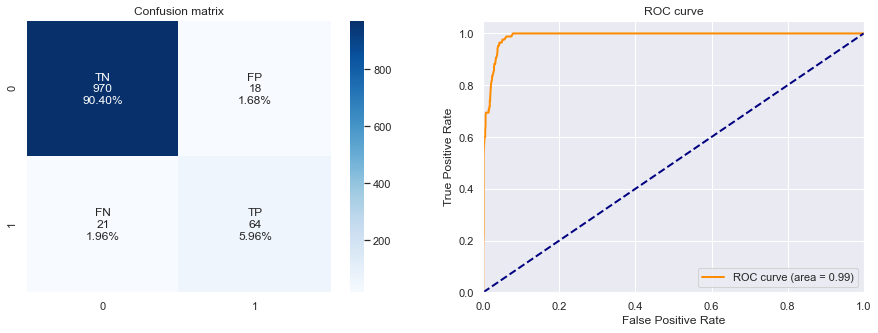

(0.9636533084808947,
 0.7804878048780488,
 0.9802930773117736,
 0.7529411764705882,
 0.9802930773117736,
 0.7664670658682634,
 0.9802930773117736,
 0.9898666349130745)

In [50]:
# classify user
X_train, X_test, y_train, y_test = train_test_split(X_user, y_user, test_size=0.2, stratify = y_user, random_state=42)


# normalization
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu ) / sigma
X_test = (X_test - mu ) / sigma

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

#model_eval('lsvm', X_train_only_texts, just_y_train, X_test_only_texts, just_y_test, print_c = True)
print('user classification: superspreader')
model_eval('rf', X_res, y_res, X_test, y_test, print_c = True)

# Sources of Misinformation

Index(['id', 'total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user',
       'misinformations', 'misinformation_ratio', 'users_misinformed',
       'misinformation_for_reached_user', 'messages',
       'source_of_misinformation', 'superspreader'],
      dtype='object')
(5364,)
(5364, 8)


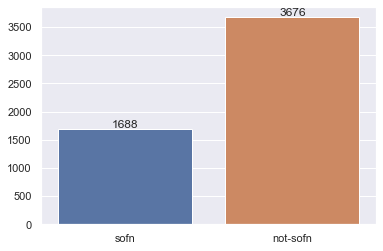

In [51]:
print(df_active_users.columns)
user_features = ['total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user']
X_user = df_active_users[user_features].to_numpy()
y_user = df_active_users['source_of_misinformation']

print(y_user.shape)
print(X_user.shape)

pos_mask = y_user == 1 
pos = y_user[pos_mask]
neg_mask = y_user == 0 
neg = y_user[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['sofn', 'not-sofn']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

user classification: source of misinformation
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       735
           1       0.77      0.86      0.82       338

    accuracy                           0.88      1073
   macro avg       0.85      0.87      0.86      1073
weighted avg       0.88      0.88      0.88      1073

AUC:  0.9303727408123013


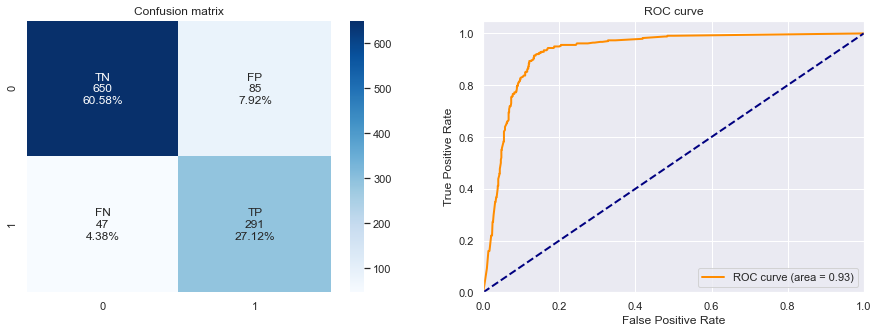

(0.8769804287045666,
 0.773936170212766,
 0.9078212290502793,
 0.8609467455621301,
 0.9078212290502793,
 0.8151260504201681,
 0.9078212290502793,
 0.9303727408123013)

In [52]:
# classify user
X_train, X_test, y_train, y_test = train_test_split(X_user, y_user, test_size=0.2, stratify = y_user, random_state=42)


# normalization
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu ) / sigma
X_test = (X_test - mu ) / sigma

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

#model_eval('lsvm', X_train_only_texts, just_y_train, X_test_only_texts, just_y_test, print_c = True)
print('user classification: source of misinformation')
model_eval('rf', X_res, y_res, X_test, y_test, print_c = True)

In [92]:
df_users['messages']

0       ontem vir vídeo travestir xingar ser blasfemar...
1        ordem mear caos sucesso escola militar curto ...
2       kkk urna fraudar kkk desculpar né kkk o nível ...
3        😂 😂 😂 😂 😂   👏 🏻 👏 🏻 👏 🏻 👏 🏻 👏 🏻  alguém vídeo...
4       bom noite caro amigo   🤝 🏼  ser bem vir endire...
                              ...                        
5359                                                  NaN
5360                                                  NaN
5361                                                     
5362    acesse link entrar grupar whatsapp chat whatsa...
5363                                                  NaN
Name: messages, Length: 5364, dtype: object

In [98]:
# enrich user data with posted messages
X_texts = vectorize_corpus(w2v, df_users['messages'])
X_user = np.concatenate((X_user, X_texts), axis=1)

<ipython-input-97-07e886f4fa06>:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = model[word]


user classification: source of misinformation with texts
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       735
           1       0.80      0.90      0.85       338

    accuracy                           0.90      1073
   macro avg       0.88      0.90      0.89      1073
weighted avg       0.91      0.90      0.90      1073

AUC:  0.9654832347140038


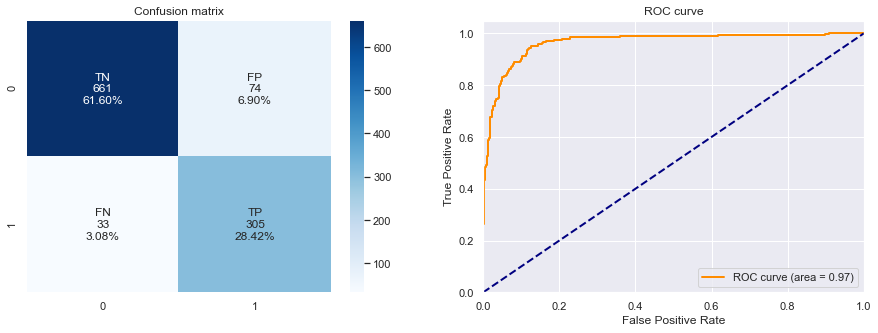

(0.9002795899347623,
 0.8047493403693932,
 0.9251224632610215,
 0.9023668639053254,
 0.9251224632610215,
 0.8507670850767085,
 0.9251224632610215,
 0.9654832347140038)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_user, y_user, test_size=0.2, stratify = y_user, random_state=42)


# normalization
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu ) / sigma
X_test = (X_test - mu ) / sigma

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

#model_eval('lsvm', X_train_only_texts, just_y_train, X_test_only_texts, just_y_test, print_c = True)
print('user classification: source of misinformation with texts')
model_eval('gb', X_res, y_res, X_test, y_test, print_c = True)

user classification: source of misinformation with texts
Iteration 1, loss = 0.49057702
Validation score: 0.816638
Iteration 2, loss = 0.34540771
Validation score: 0.843803
Iteration 3, loss = 0.29255109
Validation score: 0.859083
Iteration 4, loss = 0.25873138
Validation score: 0.872666
Iteration 5, loss = 0.23246024
Validation score: 0.884550
Iteration 6, loss = 0.21116478
Validation score: 0.891341
Iteration 7, loss = 0.19333792
Validation score: 0.904924
Iteration 8, loss = 0.17785298
Validation score: 0.898132
Iteration 9, loss = 0.16510575
Validation score: 0.903226
Iteration 10, loss = 0.15378807
Validation score: 0.906621
Iteration 11, loss = 0.14491735
Validation score: 0.915110
Iteration 12, loss = 0.13416340
Validation score: 0.921902
Iteration 13, loss = 0.12598758
Validation score: 0.915110
Iteration 14, loss = 0.11827282
Validation score: 0.918506
Iteration 15, loss = 0.11166729
Validation score: 0.916808
Iteration 16, loss = 0.10539554
Validation score: 0.923599
Iteratio

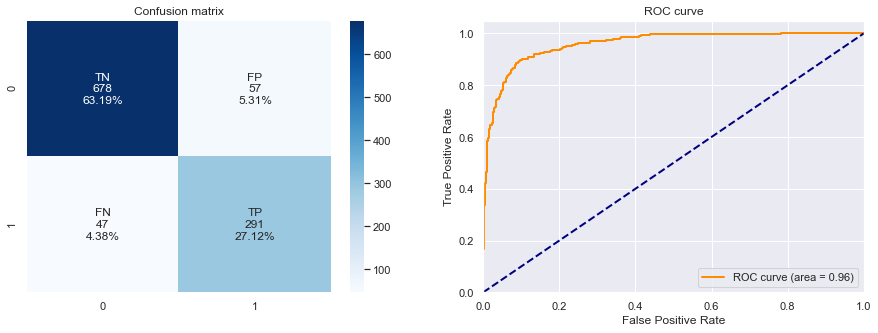

(0.9030754892823858,
 0.8362068965517241,
 0.9287671232876712,
 0.8609467455621301,
 0.9287671232876712,
 0.8483965014577258,
 0.9287671232876712,
 0.9588294489393391)

In [108]:
print('user classification: source of misinformation with texts')
model_eval('mlp', X_res, y_res, X_test, y_test, print_c = True)

In [55]:
df_users.columns

Index(['id', 'total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user',
       'misinformations', 'misinformation_ratio', 'users_misinformed',
       'misinformation_for_reached_user', 'messages',
       'source_of_misinformation', 'superspreader'],
      dtype='object')

# Enrich messages with user data

In [198]:
#df_users = df_users[['id','total_messages','texts','midia','urls','number_of_groups','reached_users','messages_for_reached_user']]
users = df_unique['id']
features = ['total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user']
users_array = np.empty(shape=[0, len(features)])
for user in users:
    user_array = df_users[df_users['id']==user][features].to_numpy()
    users_array = np.append(users_array,user_array,axis=0)
users_array.shape    

(5284, 8)

# Train-test split

In [199]:
# if 'pre_processed' in experiment:
#     X_texts = pro_texts
# else:
#     X_texts = semi_pro_texts
X_texts = pro_texts

df_only_texts = df_unique.drop_duplicates(subset=['text'])
X_only_texts = df_only_texts['preprocessed_text']
y_only_texts = df_only_texts['misinformation']
print(X_only_texts.shape)


just_texts_train, just_texts_test, just_y_train, just_y_test = train_test_split(X_only_texts, y_only_texts, test_size=0.2, 
                                                                    stratify = y_only_texts, random_state=42)

texts_train, texts_test, y_train, y_test = train_test_split(X_texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

users_train, users_test, y_train, y_test = train_test_split(users_array, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)
# vectorizing
X_train = vectorize_corpus(w2v,texts_train)
X_test = vectorize_corpus(w2v,texts_test)

X_train_only_texts = vectorize_corpus(w2v,just_texts_train)
X_test_only_texts = vectorize_corpus(w2v,just_texts_test)

(5284,)


<ipython-input-194-07e886f4fa06>:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = model[word]


In [200]:
# normalization
mu = np.mean(X_train_only_texts, 0)
sigma = np.std(X_train_only_texts, 0)
X_train_only_texts = (X_train_only_texts - mu ) / sigma
X_test_only_texts = (X_test_only_texts - mu ) / sigma

(4227, 100)
(1057, 100)
only text
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       618
           1       0.70      0.75      0.72       439

    accuracy                           0.76      1057
   macro avg       0.76      0.76      0.76      1057
weighted avg       0.77      0.76      0.76      1057

AUC:  0.8300159969333067


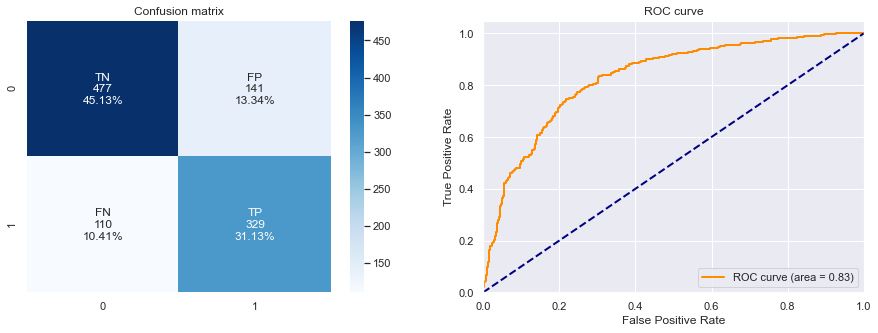

(0.7625354777672658,
 0.7,
 0.791701244813278,
 0.7494305239179955,
 0.791701244813278,
 0.7238723872387239,
 0.791701244813278,
 0.8300159969333067)

In [201]:
print(X_train.shape)
print(X_test.shape)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_only_texts, just_y_train)

#model_eval('lsvm', X_train_only_texts, just_y_train, X_test_only_texts, just_y_test, print_c = True)
print('only text')
model_eval('mlp', X_res, y_res, X_test_only_texts, just_y_test, print_c = True)
# acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc



# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)
# clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1).fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_prob = clf.predict_proba(X_test)[:,1]
# getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts= True)
# tree.plot_tree(clf) 


no oversampling
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       618
           1       0.72      0.72      0.72       439

    accuracy                           0.77      1057
   macro avg       0.76      0.76      0.76      1057
weighted avg       0.77      0.77      0.77      1057

AUC:  0.8388179961813772


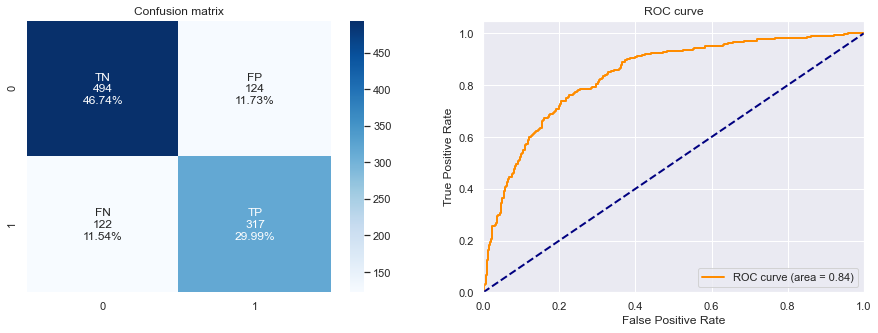

(0.7672658467360454,
 0.7188208616780045,
 0.80064829821718,
 0.7220956719817767,
 0.80064829821718,
 0.7204545454545453,
 0.80064829821718,
 0.8388179961813772)

In [202]:
# with user features
X_train_merged = np.concatenate((X_train, users_train), axis=1)
X_test_merged = np.concatenate((X_test, users_test), axis=1)
# normalization
mu = np.mean(X_train_merged, 0)
sigma = np.std(X_train_merged, 0)
X_train_merged = (X_train_merged - mu ) / sigma
X_test_merged = (X_test_merged - mu ) / sigma

# oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_merged, y_train)

print('no oversampling')
model_eval('mlp', X_train_merged, y_train, X_test_merged, y_test, print_c = True)
# print('oversampling')
# model_eval('lsvm', X_res, y_res, X_test_merged, y_test, print_c = True)
# lsvm f1 0.78

## Data Leakage

In [203]:
mlp = MLPClassifier(verbose=False, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]

In [204]:
len(y_test)

1057

In [205]:
# testing for data leakage
set_test = {tuple(row) for row in X_test}
set_train = {tuple(row) for row in X_train}

In [206]:
leakage = set_train.intersection(set_test)
len(leakage)

33

In [207]:
mask_leakage = []
for row in X_test:
    tup = tuple(row)
    if tup in leakage:
        mask_leakage.append(True)
    else:
        mask_leakage.append(False)
        
pred_leakage = y_pred[mask_leakage]
y_leakage = y_test[mask_leakage]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        41
           1       0.88      0.88      0.88        17

    accuracy                           0.93        58
   macro avg       0.92      0.92      0.92        58
weighted avg       0.93      0.93      0.93        58



(0.9310344827586207,
 0.8823529411764706,
 0.9512195121951219,
 0.8823529411764706,
 0.9512195121951219,
 0.8823529411764706,
 0.9512195121951219,
 0)

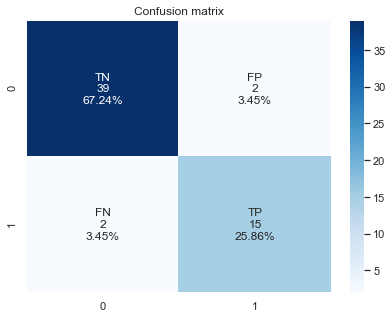

In [208]:
getTestMetrics(y_leakage, pred_leakage, full_metrics = True, print_charts=True)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       577
           1       0.72      0.66      0.69       422

    accuracy                           0.75       999
   macro avg       0.74      0.74      0.74       999
weighted avg       0.75      0.75      0.75       999



(0.7477477477477478,
 0.7190721649484536,
 0.7878787878787878,
 0.6611374407582938,
 0.7878787878787878,
 0.6888888888888889,
 0.7878787878787878,
 0)

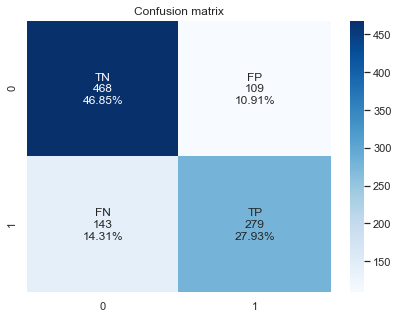

In [209]:
not_mask_leakage = [not m for m in mask_leakage]
pred_leakage = y_pred[not_mask_leakage]
y_leakage = y_test[not_mask_leakage]
getTestMetrics(y_leakage, pred_leakage, full_metrics = True, print_charts=True)

# Enrich text with users data who posted message

In [210]:
features = ['total_messages', 'viral_messages', 'texts', 'midia', 'urls',
               'number_of_groups', 'reached_users', 'messages_for_reached_user']
print(df_users.columns)

Index(['id', 'total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user',
       'misinformations', 'misinformation_ratio', 'users_misinformed',
       'misinformation_for_reached_user', 'messages',
       'source_of_misinformation', 'superspreader'],
      dtype='object')


In [211]:
def array_stats(array, concat_array, stat = 'mean'):
    if stat == 'mean':
        stat_array = array.mean(axis=0)
    elif stat == 'max':
        stat_array = array.max(axis=0)
    elif stat == 'min':
        stat_array = array.min(axis=0)
    elif stat == 'std':
        stat_array = array.std(axis=0)
    elif stat == 'median':
        stat_array = np.median(array,axis=0)
        
    stat_array = np.reshape(stat_array,(1,stat_array.size))
    concat_array = np.append(concat_array, stat_array, axis=0)
    return concat_array
    

In [212]:
users_means = np.empty(shape=[0, len(features)])
users_maxs= np.empty(shape=[0, len(features)])
users_mins = np.empty(shape=[0, len(features)])
users_stds = np.empty(shape=[0, len(features)])
users_medians = np.empty(shape=[0, len(features)])

for text in df_only_texts['text']:
    df_messages = df[df['text'] == text] # change to 90% of similarity
    users = df_messages['id'].unique()
    users_array = np.empty(shape=[0, len(features)])
    
    for user in users:
        user_array = df_users[df_users['id']==user][features].to_numpy()
        users_array = np.append(users_array,user_array,axis=0)
        
    # use mean, std, median, max, min
    users_means = array_stats(users_array, users_means, stat = 'mean')
    users_maxs = array_stats(users_array, users_maxs, stat = 'max')
    users_mins = array_stats(users_array, users_mins, stat = 'min')
    users_stds = array_stats(users_array, users_stds, stat = 'std')
    users_medians = array_stats(users_array, users_medians, stat = 'median')  
    

In [213]:
users_stats = np.concatenate((users_means,users_medians,users_stds,users_maxs,users_mins),axis=1)
users_stats.shape

(5284, 40)

In [214]:
texts_train, texts_test, y_train, y_test = train_test_split(X_only_texts, y_only_texts, test_size=0.2, 
                                                                    stratify = y_only_texts, random_state=42)

users_train, users_test, y_train, y_test = train_test_split(users_stats,y_only_texts, test_size=0.2, 
                                                                    stratify = y_only_texts, random_state=42)

# vectorizing
X_train = vectorize_corpus(w2v,texts_train)
X_test = vectorize_corpus(w2v,texts_test)

<ipython-input-194-07e886f4fa06>:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = model[word]


              precision    recall  f1-score   support

           0       0.82      0.79      0.80       618
           1       0.72      0.76      0.74       439

    accuracy                           0.78      1057
   macro avg       0.77      0.77      0.77      1057
weighted avg       0.78      0.78      0.78      1057

AUC:  0.8390760112347126


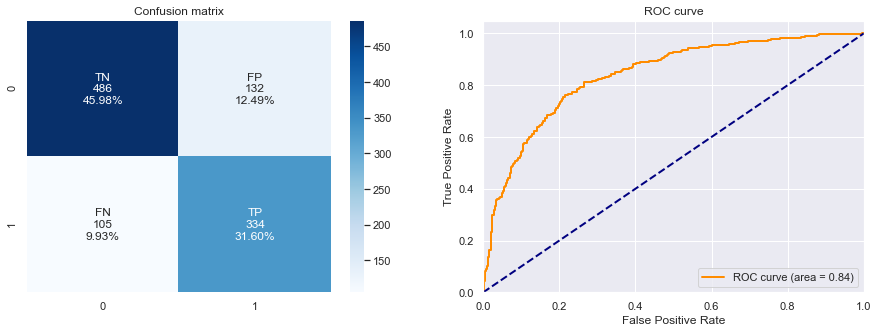

(0.7757805108798487,
 0.7167381974248928,
 0.803970223325062,
 0.7608200455580866,
 0.803970223325062,
 0.738121546961326,
 0.803970223325062,
 0.8390760112347126)

In [215]:
# only text
# normalization
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train_merged = (X_train - mu ) / sigma
X_test_merged = (X_test - mu ) / sigma

# oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)


model_eval('mlp', X_res, y_res, X_test, y_test, print_c = True)

user features
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       618
           1       0.72      0.72      0.72       439

    accuracy                           0.77      1057
   macro avg       0.76      0.76      0.76      1057
weighted avg       0.77      0.77      0.77      1057

AUC:  0.8373215088720318


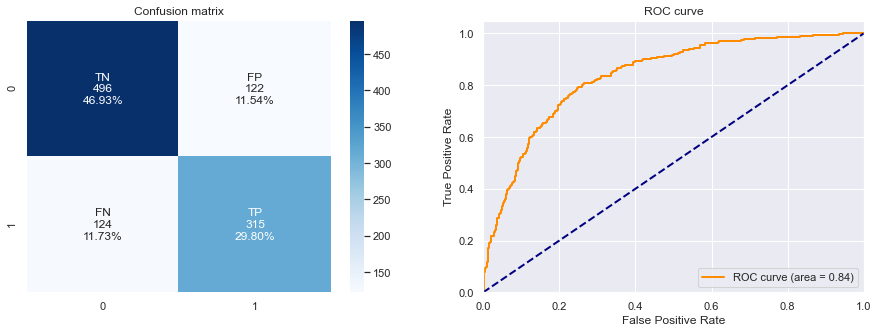

(0.7672658467360454,
 0.7208237986270023,
 0.8012924071082391,
 0.7175398633257403,
 0.8012924071082391,
 0.7191780821917807,
 0.8012924071082391,
 0.8373215088720318)

In [216]:
# with user features
X_train_merged = np.concatenate((X_train, users_train), axis=1)
X_test_merged = np.concatenate((X_test, users_test), axis=1)
# normalization
mu = np.mean(X_train_merged, 0)
sigma = np.std(X_train_merged, 0)
X_train_merged = (X_train_merged - mu ) / sigma
X_test_merged = (X_test_merged - mu ) / sigma

# oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_merged, y_train)

#print('no oversampling')
print('user features')
model_eval('mlp', X_res, y_res, X_test_merged, y_test, print_c = True)
#model_eval('mlp', X_train_merged, y_train, X_test_merged, y_test, print_c = True)

only users
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       618
           1       0.53      0.56      0.54       439

    accuracy                           0.61      1057
   macro avg       0.60      0.60      0.60      1057
weighted avg       0.61      0.61      0.61      1057

AUC:  0.6419322378751355


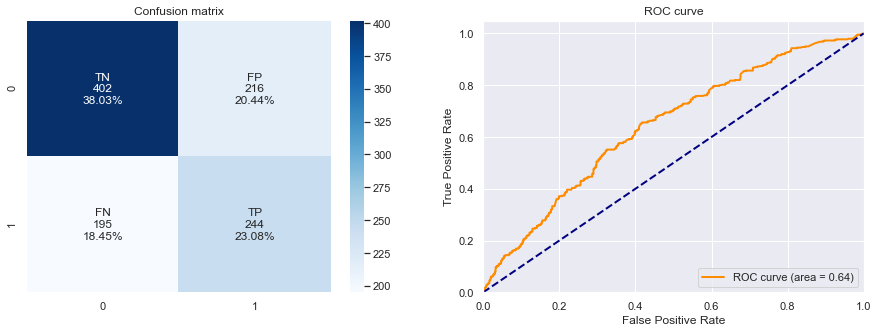

(0.6111636707663197,
 0.5304347826086957,
 0.6617283950617283,
 0.5558086560364465,
 0.6617283950617283,
 0.5428253615127921,
 0.6617283950617283,
 0.6419322378751355)

In [217]:
# only users
print('only users')

# normalization
mu = np.mean(users_train, 0)
sigma = np.std(users_train, 0)
users_train = (users_train - mu ) / sigma
users_test = (users_test - mu ) / sigma

# oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(users_train, y_train)

#print('no oversampling')
model_eval('mlp', X_res, y_res, users_test, y_test, print_c = True)